<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/2022project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import PIL
import time
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import plotly.graph_objs as go
from tensorflow import keras
from tensorflow.keras.models import Sequential

## เตรียมชุดของข้อมูล

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')
path = '/content/drive/My Drive/2022Project/dataeye'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/2022Project/dataeye')

In [4]:
batch_size = 64   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 224  # ความสูงของรูปภาพแต่ละรูป
img_width = 224   # ความกว้างของรูปภาพแต่ละรูป

## Train

In [5]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.1, # s แบ่งข้อมูล เพื่อ training 90% และ validation 10%
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.1,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 16556 files belonging to 3 classes.
Using 14901 files for training.
Found 16556 files belonging to 3 classes.
Using 1655 files for validation.


In [6]:
class_names = train.class_names
print(class_names)

['Crop CSC', 'Crop PCV', 'Crop VKH']


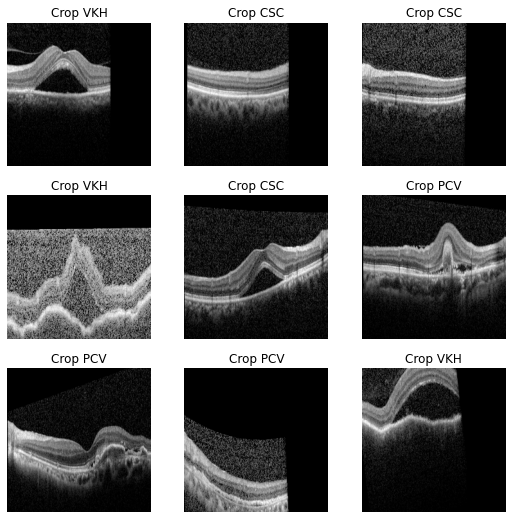

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 9)) #ขนาด
for images, labels in train.take(1):
  for i in range(9): #มี 9 รูป
    ax = plt.subplot(3, 3, i + 1) #แถวละ 3
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


## Normalization

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99369746


## Model

In [10]:
num_classes = 3
epochs=30   # จำนวนครั้งที่เราจะ Train

In [11]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [13]:
his = model.fit(
train,
validation_data=val,
epochs=epochs
)

Epoch 1/30
233/233 [==============================] - 137s 531ms/step - loss: 0.9919 - accuracy: 0.5048 - val_loss: 0.7498 - val_accuracy: 0.6743
Epoch 2/30
233/233 [==============================] - 132s 551ms/step - loss: 0.5740 - accuracy: 0.7610 - val_loss: 0.4070 - val_accuracy: 0.8393
Epoch 3/30
233/233 [==============================] - 129s 536ms/step - loss: 0.2917 - accuracy: 0.8888 - val_loss: 0.3085 - val_accuracy: 0.8852
Epoch 4/30
233/233 [==============================] - 125s 521ms/step - loss: 0.1370 - accuracy: 0.9508 - val_loss: 0.2288 - val_accuracy: 0.9221
Epoch 5/30
233/233 [==============================] - 124s 517ms/step - loss: 0.0520 - accuracy: 0.9827 - val_loss: 0.3455 - val_accuracy: 0.9027
Epoch 6/30
233/233 [==============================] - 129s 537ms/step - loss: 0.0272 - accuracy: 0.9915 - val_loss: 0.3181 - val_accuracy: 0.9215
Epoch 7/30
233/233 [==============================] - 128s 535ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.2877 -

## Save Model

In [14]:
with open('history_model', 'wb') as file:
   p.dump(his.history, file)

filepath='model1.h5'
model.save(filepath)
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


## Load Model

In [15]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['loss'],
mode="lines", line=dict(
width=2,
color='blue'),
name="loss"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testMNIST")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

## Prediction

1/1 [==============================] - 1s 614ms/step
Crop CSC tf.Tensor(1.0, shape=(), dtype=float32) Crop PCV tf.Tensor(4.3867955e-16, shape=(), dtype=float32) Crop VKH tf.Tensor(9.342281e-15, shape=(), dtype=float32)


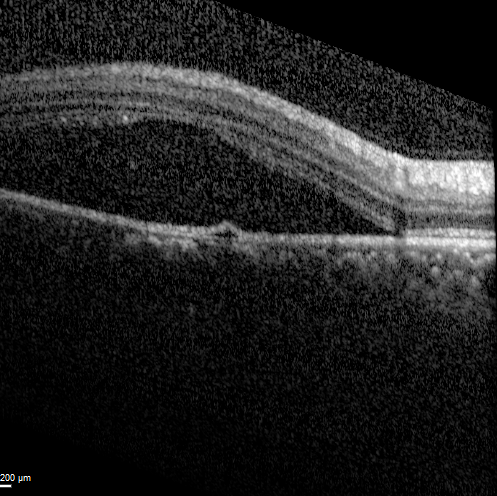

AI Crop CSC มีความมั่นใจ 100.00%.


In [16]:
import requests
from IPython.display import Image
from io import BytesIO
test_path = ('/content/drive/My Drive/testeye/testc.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
Crop CSC tf.Tensor(0.073612794, shape=(), dtype=float32) Crop PCV tf.Tensor(0.92638725, shape=(), dtype=float32) Crop VKH tf.Tensor(3.6226808e-09, shape=(), dtype=float32)


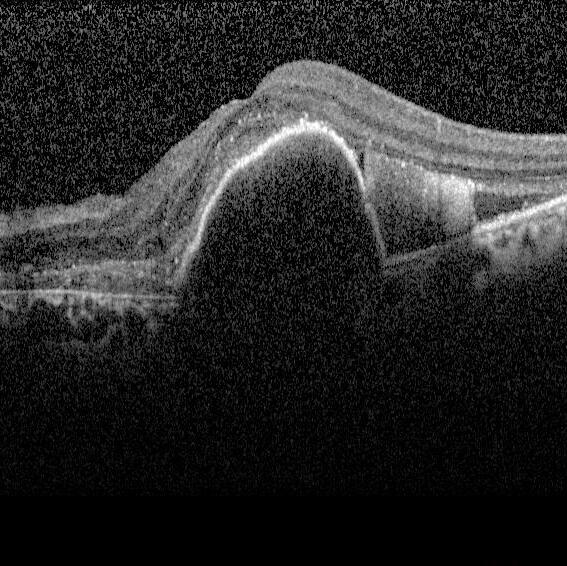

AI Crop PCV มีความมั่นใจ 92.64%.


In [17]:
test_path = ('/content/drive/My Drive/testeye/testp.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 19ms/step
Crop CSC tf.Tensor(0.9999999, shape=(), dtype=float32) Crop PCV tf.Tensor(6.918072e-19, shape=(), dtype=float32) Crop VKH tf.Tensor(1.17962834e-07, shape=(), dtype=float32)


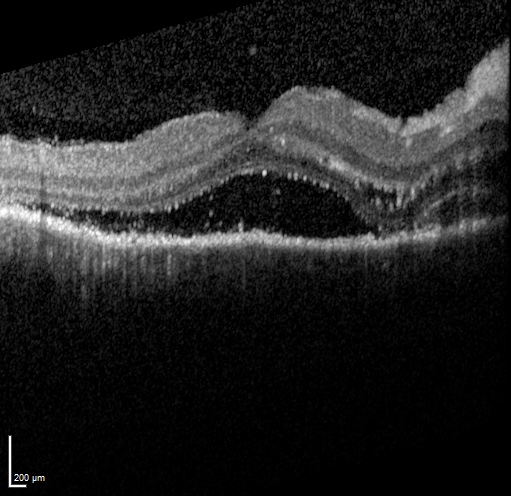

AI Crop CSC มีความมั่นใจ 100.00%.


In [18]:
test_path = ('/content/drive/My Drive/testeye/testv.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

# Test

In [37]:
data_test = pathlib.Path('/content/drive/MyDrive/2022Project/testdataeye')

In [40]:
test = tf.keras.utils.image_dataset_from_directory(data_test,image_size=(img_height, img_width))

Found 30 files belonging to 3 classes.


In [41]:
y_test = []; y_pred = []
for images, labels in test.take(1):
  for i in range(len(list(data_test.glob('*/*.png')))):
    img_array = keras.preprocessing.image.img_to_array(images[i])
    X_test = tf.expand_dims(img_array, 0)
    score = predict_model.predict(X_test)
    if score[0][0]==np.max(score):
      eye = "Crop CSC"
    elif score[0][1]==np.max(score):
      eye = "Crop PCV"
    elif score[0][2]==np.max(score):
      eye = "Crop VKH"
    y_pred.append(eye)
    y_test.append(class_names[labels[i]]) # ได้แค่ 32

1/1 [==============================] - 0s 17ms/step


In [42]:
print(y_test)
print(y_pred)

['Crop CSC', 'Crop CSC', 'Crop VKH', 'Crop PCV', 'Crop CSC', 'Crop VKH', 'Crop VKH', 'Crop VKH', 'Crop PCV', 'Crop CSC', 'Crop PCV', 'Crop PCV', 'Crop VKH', 'Crop PCV', 'Crop PCV', 'Crop CSC', 'Crop PCV', 'Crop PCV', 'Crop PCV', 'Crop CSC', 'Crop CSC', 'Crop VKH', 'Crop CSC', 'Crop VKH', 'Crop VKH', 'Crop CSC', 'Crop VKH', 'Crop VKH', 'Crop PCV', 'Crop CSC']
['Crop CSC', 'Crop CSC', 'Crop VKH', 'Crop PCV', 'Crop CSC', 'Crop VKH', 'Crop VKH', 'Crop VKH', 'Crop PCV', 'Crop CSC', 'Crop PCV', 'Crop PCV', 'Crop VKH', 'Crop PCV', 'Crop PCV', 'Crop CSC', 'Crop PCV', 'Crop PCV', 'Crop PCV', 'Crop CSC', 'Crop CSC', 'Crop VKH', 'Crop CSC', 'Crop VKH', 'Crop VKH', 'Crop CSC', 'Crop VKH', 'Crop VKH', 'Crop PCV', 'Crop CSC']


# Confusion Matrix

In [43]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
confusion_matrix(y_test, y_pred)

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]])

In [45]:
cm = confusion_matrix(y_test, y_pred)

In [46]:
test.class_names

['csc', 'pcv', 'vkh']

In [47]:
cm_df = pd.DataFrame(cm,
                     index = ['Crop CSC','Crop PCV','Crop VKH'], 
                     columns = ['Crop CSC','Crop PCV','Crop VKH'])

In [48]:
cm_df

,Crop CSC,Crop PCV,Crop VKH
Crop CSC,10,0,0
Crop PCV,0,10,0
Crop VKH,0,0,10


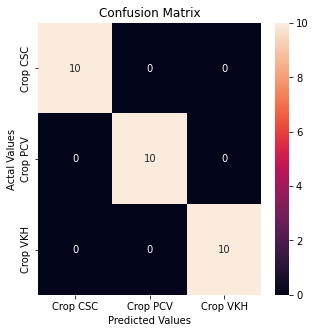

In [49]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Learning curve

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt

In [74]:
import pandas as pd

In [75]:
data = cm_df
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, Crop CSC to Crop VKH
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Crop    3 non-null      int64
 1   Crop    3 non-null      int64
 2   Crop    3 non-null      int64
dtypes: int64(3)
memory usage: 96.0+ bytes
None


,Crop,Crop,Crop
Crop CSC,10,0,0
Crop PCV,0,10,0
Crop VKH,0,0,10


In [76]:
# rename the columns
renamed_columns = [col.split()[0] for col in data.columns]
renamed_columns_map = {data.columns[i]:renamed_columns[i] for i in range(len(data.columns))}

data.rename(renamed_columns_map, axis=1, inplace=True)

In [161]:
# separate features and target data
features, target = data.columns[:1], data.columns[1]

X = data[features]
y = data[target]

In [155]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from yellowbrick.model_selection import LearningCurve

In [156]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=3)
sizes = np.linspace(0.3, 1.0, 30)

In [157]:
# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=3
)

In [158]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X, y, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 2))

In [159]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

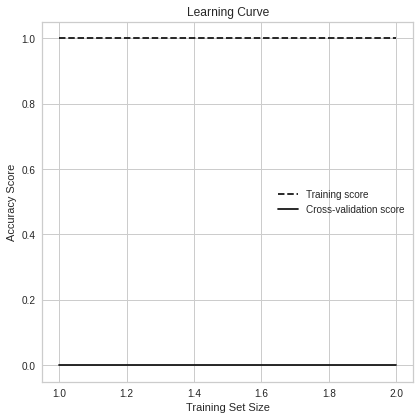

In [160]:
plt.subplots(1, figsize=(6,6))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()